In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch

In [3]:
import pandas as pd

TEST_DATA = 'input/test_private_expanded.csv'
test = pd.read_csv(TEST_DATA, index_col='id')
test.head()

,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,...,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
id,,,,,,,,,,,,,,,,,,,,,
7097320,[ Integrity means that you pay your debts.]\n\...,2017-09-13 20:12:01.484121+00,21,5945023.0,376974,approved,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7097321,This is malfeasance by the Administrator and t...,2017-05-17 07:01:51.902566+00,55,NaN,335003,approved,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7097322,@Rmiller101 - Spoken like a true elitist. But ...,2016-12-02 17:12:12.920957+00,54,649389.0,154126,approved,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7097323,"Paul: Thank you for your kind words. I do, in...",2017-04-21 14:58:05.474657+00,13,5158666.0,328376,approved,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7097324,Sorry you missed high school. Eisenhower sent ...,2017-10-01 19:43:12.373229+00,102,6061626.0,383983,approved,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, Sampler
import string
import re
import json
from sklearn.utils import shuffle
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from tqdm import tqdm

max_len = 220
batch_size = 512
seed = 1029
EMBEDDING_FASTTEXT = './input/crawl-300d-2M.vec'
max_features = 100000
embed_size = 300

ps = PorterStemmer()
lc = LancasterStemmer()
sb = SnowballStemmer('english')

# preprocessing
misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not",
                 "didn't": "did not", "doesn't": "does not", "don't": "do not",
                 "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would", "he'll": "he will", "he's": "he is",
                 "i'd": "I had", "i'll": "I will", "i'm": "I am", "isn't": "is not",
                 "it's": "it is", "it'll": "it will", "i've": "I have", "let's": "let us",
                 "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
                 "she'd": "she would", "she'll": "she will", "she's": "she is",
                 "shouldn't": "should not", "that's": "that is", "there's": "there is",
                 "they'd": "they would", "they'll": "they will", "they're": "they are",
                 "they've": "they have", "we'd": "we would", "we're": "we are",
                 "weren't": "were not", "we've": "we have", "what'll": "what will",
                 "what're": "what are", "what's": "what is", "what've": "what have",
                 "where's": "where is", "who'd": "who would", "who'll": "who will",
                 "who're": "who are", "who's": "who is", "who've": "who have",
                 "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                 "you'll": "you will", "you're": "you are", "you've": "you have",
                 "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying"}


def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, text)
    

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub(r'\d+', ' ', x)

# load dataframe
def load_and_prec(df):
    test = df
    # lower
    test['comment_text'] = test['comment_text'].str.lower()

    # clean misspellings
    test['comment_text'] = test['comment_text'].apply(replace_typical_misspell)

    # clean the text
    test['comment_text'] = test['comment_text'].apply(clean_text)

    # clean numbers
    test['comment_text'] = test['comment_text'].apply(clean_numbers)
    
    # strip
    test['comment_text'] = test['comment_text'].str.strip()
    
    # replace blank with nan
    test['comment_text'].replace('', np.nan, inplace=True)

    
    # fill up the missing values
    test_x = test['comment_text'].fillna('_##_').values
    
    # get the target values
    identity_columns = [
        'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
        'muslim', 'black', 'white', 'psychiatric_or_mental_illness']



    return test_x

from torch import nn

class NeuralNet(nn.Module):

    def __init__(self, embedding_matrix):
        super(NeuralNet, self).__init__()

        lstm_hidden_size = 120
        gru_hidden_size = 60
        self.gru_hidden_size = gru_hidden_size

        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.2)

        self.lstm = nn.LSTM(embedding_matrix.shape[1], lstm_hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(lstm_hidden_size * 2, gru_hidden_size, bidirectional=True, batch_first=True)

        self.linear = nn.Linear(gru_hidden_size * 6, 20)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(20, 1)
        
    def apply_spatial_dropout(self, h_embedding):
        h_embedding = h_embedding.transpose(1, 2).unsqueeze(2)
        h_embedding = self.embedding_dropout(h_embedding).squeeze(2).transpose(1, 2)
        return h_embedding

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.apply_spatial_dropout(h_embedding)

        h_lstm, _ = self.lstm(h_embedding)
        h_gru, hh_gru = self.gru(h_lstm)

        hh_gru = hh_gru.view(-1, self.gru_hidden_size * 2)

        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)

        conc = torch.cat((hh_gru, avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)

        return out

class BucketSampler(Sampler):

    def __init__(self, data_source, sort_keys, bucket_size=None, batch_size=1048, shuffle_data=True):
        super().__init__(data_source)
        self.shuffle = shuffle_data
        self.batch_size = batch_size
        self.sort_keys = sort_keys
        self.bucket_size = bucket_size if bucket_size is not None else len(sort_keys)
        self.weights = None

        if not shuffle_data:
            self.index = self.prepare_buckets()
        else:
            self.index = None

    def set_weights(self, weights):
        assert weights >= 0
        total = np.sum(weights)
        if total != 1:
            weights = weights / total
        self.weights = weights

    def __iter__(self):
        indices = None
        if self.weights is not None:
            total = len(self.sort_keys)
            indices = np.random.choice(total, (total,), p=self.weights)
        if self.shuffle:
            self.index = self.prepare_buckets(indices)
        return iter(self.index)

    def get_reverse_indexes(self):
        indexes = np.zeros((len(self.index),), dtype=np.int32)
        for i, j in enumerate(self.index):
            indexes[j] = i
        return indexes

    def __len__(self):
        return len(self.sort_keys)
        
    def prepare_buckets(self, indices=None):
        lens = - self.sort_keys
        assert self.bucket_size % self.batch_size == 0 or self.bucket_size == len(lens)

        if indices is None:
            if self.shuffle:
                indices = shuffle(np.arange(len(lens), dtype=np.int32))
                lens = lens[indices]
            else:
                indices = np.arange(len(lens), dtype=np.int32)

        #  bucket iterator
        def divide_chunks(l, n):
            if n == len(l):
                yield np.arange(len(l), dtype=np.int32), l
            else:
                # looping till length l
                for i in range(0, len(l), n):
                    data = l[i:i + n]
                    yield np.arange(i, i + len(data), dtype=np.int32), data
    
        new_indices = []
        extra_batch = None
        for chunk_index, chunk in divide_chunks(lens, self.bucket_size):
            # sort indices in bucket by descending order of length
            indices_sorted = chunk_index[np.argsort(chunk, axis=-1)]
            batches = []
            for _, batch in divide_chunks(indices_sorted, self.batch_size):
                if len(batch) == self.batch_size:
                    batches.append(batch.tolist())
                else:
                    assert extra_batch is None
                    assert batch is not None
                    extra_batch = batch
    
            # shuffling batches within buckets
            if self.shuffle:
                batches = shuffle(batches)
            for batch in batches:
                new_indices.extend(batch)
    
        if extra_batch is not None:
            new_indices.extend(extra_batch)
        return indices[new_indices]


class TextDataset(Dataset):

    def __init__(self, seqs, targets=None, maxlen=200):
        if targets is not None:
            self.targets = targets
        else:
            self.targets = np.random.randint(2, size=(len(seqs),))
        
        self.seqs = seqs
        self.maxlen = maxlen
        
    def __len__(self):
        return len(self.seqs)
        
    def get_keys(self):
        lens = np.fromiter(
            ((min(self.maxlen, len(seq))) for seq in self.seqs),
            dtype=np.int32)
        return lens
        
    def __getitem__(self, index):
        return index, self.seqs[index], self.targets[index]

def collate_fn(data):
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
        max_len = max(lens)

        padded_seqs = torch.zeros(len(seqs), max_len).long()
        for i, seq in enumerate(seqs):
            start = max_len - lens[i]
            padded_seqs[i, start:] = torch.LongTensor(seq)
        return padded_seqs

    index, seqs, targets = zip(*data)
    seqs = _pad_sequences(seqs)
    return index, seqs, torch.FloatTensor(targets)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def eval_model(model, data_loader):
    model.eval()
    preds_fold = np.zeros(len(data_loader.dataset))

    with torch.no_grad():
        for index, x_batch, y_batch in data_loader:
            x_batch = x_batch.to("cuda")
            y_batch = y_batch.to("cuda")
            y_pred = model(x_batch).detach()
            preds_fold[list(index)] = sigmoid(y_pred.cpu().numpy())[:, 0]

    return preds_fold


def tokenize(texts, vocab):

    def text2ids(text, token2id):
        return [
            token2id.get(token, len(token2id) - 1)
            for token in text.split()[:max_len]] + [0] * max(0, max_len - len(text.split()))
    
    return [
        text2ids(text, vocab['token2id'])
        for text in texts]


def load_embedding(embedding_path, word_index):

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*o.strip().split(' ')) for o in open(embedding_path))
    
    # word_index = tokenizer.word_index
    nb_words = min(max_features + 2, len(word_index))
    embedding_matrix = np.zeros((nb_words, embed_size))

    for key, i in word_index.items():
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue

    return embedding_matrix


with open('vocab.json', 'r') as f:
    vocab = json.load(f)

embedding_matrix = load_embedding(EMBEDDING_FASTTEXT, vocab['token2id'])

test_x = load_and_prec(test)
test_x = np.array(tokenize(test_x, vocab))
test_dataset = TextDataset(test_x, maxlen=max_len)
test_sampler = BucketSampler(test_dataset, test_dataset.get_keys(),
                                 batch_size=batch_size, shuffle_data=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler,
                             shuffle=False, num_workers=0, collate_fn=collate_fn)

In [5]:

models = torch.load('model.pt')
models.keys()

for name in tqdm(models.keys(), total=len(models), desc='Loading models'):
    new_model = NeuralNet(embedding_matrix).to("cuda")
    new_model.load_state_dict(models[name])
    models[name] = new_model
    models[name].eval()

Loading models:   0%|          | 0/37 [00:00<?, ?it/s]

Loading models: 100%|██████████| 37/37 [00:06<00:00,  5.61it/s]


In [6]:

def inference(comments, models, tokenized=False):
    if not tokenized:
        test_x = np.array(tokenize(comments, vocab))
    else:
        test_x = comments
    test_dataset = TextDataset(test_x, maxlen=max_len)
    test_sampler = BucketSampler(test_dataset, test_dataset.get_keys(),
                                 batch_size=batch_size, shuffle_data=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler,
                             shuffle=False, num_workers=0, collate_fn=collate_fn)

    preds = []
    ema_preds = []
    
    first_phase_preds = [eval_model(models["model"], test_loader), eval_model(models["ema_model"], test_loader)]


    for name, model in models.items():
        # skip first phase
        if name in ["model", "ema_model"]:
            continue

        if name.startswith('ema'):
            ema_preds.append(eval_model(model, test_loader))
        else:
            preds.append(eval_model(model, test_loader))
    preds = np.mean(preds, axis=0)
    ema_preds = np.mean(ema_preds, axis=0)
    return np.mean([preds, ema_preds], axis=0) * 0.9 + np.mean(first_phase_preds, axis=0) * 0.1


inference(['hello', "again", "hello", "hello"], models)



array([0.01554309, 0.02117429, 0.01562894, 0.01578098])

In [7]:
preds = inference(test["comment_text"].to_list(), models)
preds

array([0.03116038, 0.12300074, 0.34431153, ..., 0.72047993, 0.4185283 ,
       0.06720504])

In [8]:
test["prediction"] = preds
test

,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,...,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,prediction
id,,,,,,,,,,,,,,,,,,,,,
7097320,[ integrity means that you pay your debts ....,2017-09-13 20:12:01.484121+00,21,5945023.0,376974,approved,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031160
7097321,this is malfeasance by the administrator and t...,2017-05-17 07:01:51.902566+00,55,NaN,335003,approved,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123001
7097322,@ rmiller - spoken like a true elitist ...,2016-12-02 17:12:12.920957+00,54,649389.0,154126,approved,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344312
7097323,paul : thank you for your kind words . ...,2017-04-21 14:58:05.474657+00,13,5158666.0,328376,approved,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076896
7097324,sorry you missed high school . eisenhower s...,2017-10-01 19:43:12.373229+00,102,6061626.0,383983,approved,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7194635,he should lose his job for promoting mis - i...,2017-06-24 15:03:18.681506+00,54,5235573.0,333226,approved,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093596
7194636,""" thinning project is meant to lower fire dan...",2017-09-22 22:23:14.612476+00,13,NaN,380644,approved,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.118730
7194637,i hope you millennials are happy that you put ...,2017-01-25 03:07:25.614392+00,54,NaN,163903,rejected,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.720480


In [9]:
# import roc_auc
from sklearn.metrics import roc_auc_score

roc_auc_score((test['toxicity'] >= 0.5).astype(int), (test['prediction'] >= 0.5).astype(int)) # TODO: must be by group

0.8366646171940891

In [10]:
models.keys()

dict_keys(['model', 'ema_model', 'model_00', 'model_01', 'model_02', 'model_03', 'model_04', 'model_05', 'ema_model_0', 'model_10', 'model_11', 'model_12', 'model_13', 'model_14', 'model_15', 'ema_model_1', 'model_20', 'model_21', 'model_22', 'model_23', 'model_24', 'model_25', 'ema_model_2', 'model_30', 'model_31', 'model_32', 'model_33', 'model_34', 'model_35', 'ema_model_3', 'model_40', 'model_41', 'model_42', 'model_43', 'model_44', 'model_45', 'ema_model_4'])

# Split the data into different subpopulations and plot distributions

In [11]:
columns_to_remove = ['comment_text', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', "identity_annotator_count", "toxicity_annotator_count"]
out_of_competition_traits = ["severe_toxicity", "obscene", "identity_attack", "insult", "threat", "sexual_explicit"]
columns_to_remove += out_of_competition_traits

subpopulations = [i for i in test.columns.to_list() if i not in columns_to_remove]
subpopulations, len(subpopulations)

(['funny',
  'wow',
  'sad',
  'likes',
  'disagree',
  'toxicity',
  'male',
  'female',
  'transgender',
  'other_gender',
  'heterosexual',
  'homosexual_gay_or_lesbian',
  'bisexual',
  'other_sexual_orientation',
  'christian',
  'jewish',
  'muslim',
  'hindu',
  'buddhist',
  'atheist',
  'other_religion',
  'black',
  'white',
  'asian',
  'latino',
  'other_race_or_ethnicity',
  'physical_disability',
  'intellectual_or_learning_disability',
  'psychiatric_or_mental_illness',
  'other_disability',
  'prediction'],
 31)

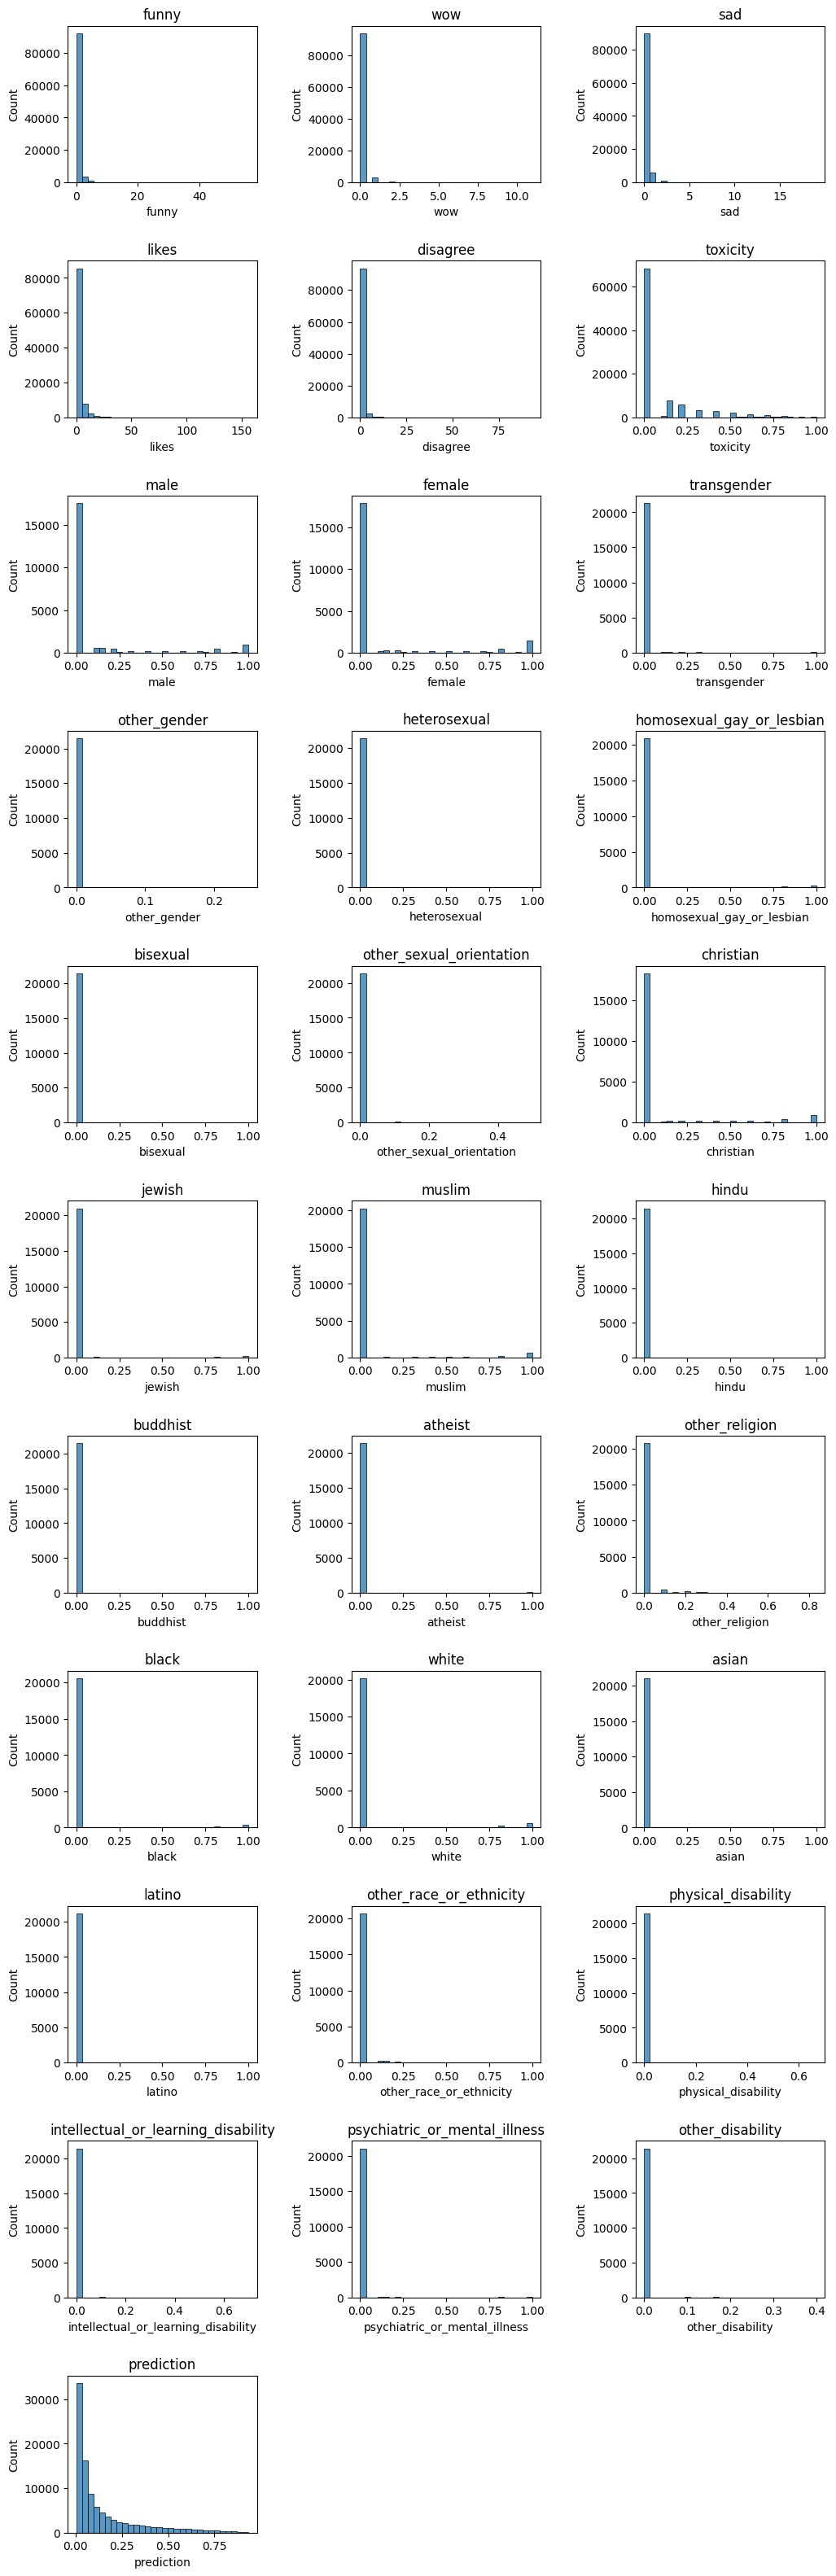

In [12]:
# We’ll split our data into different subpopulations and plot distributions in Colab.

import matplotlib.pyplot as plt
import seaborn as sns

plot_columns = 3
plot_rows = len(subpopulations) // plot_columns + 1

plt.figure(figsize=(12, 40))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i, subpopulation in enumerate(subpopulations):
    plt.subplot(plot_rows, plot_columns, i+1)
    sns.histplot(test[subpopulation], bins=30)#, kde=True)
    plt.title(subpopulation)

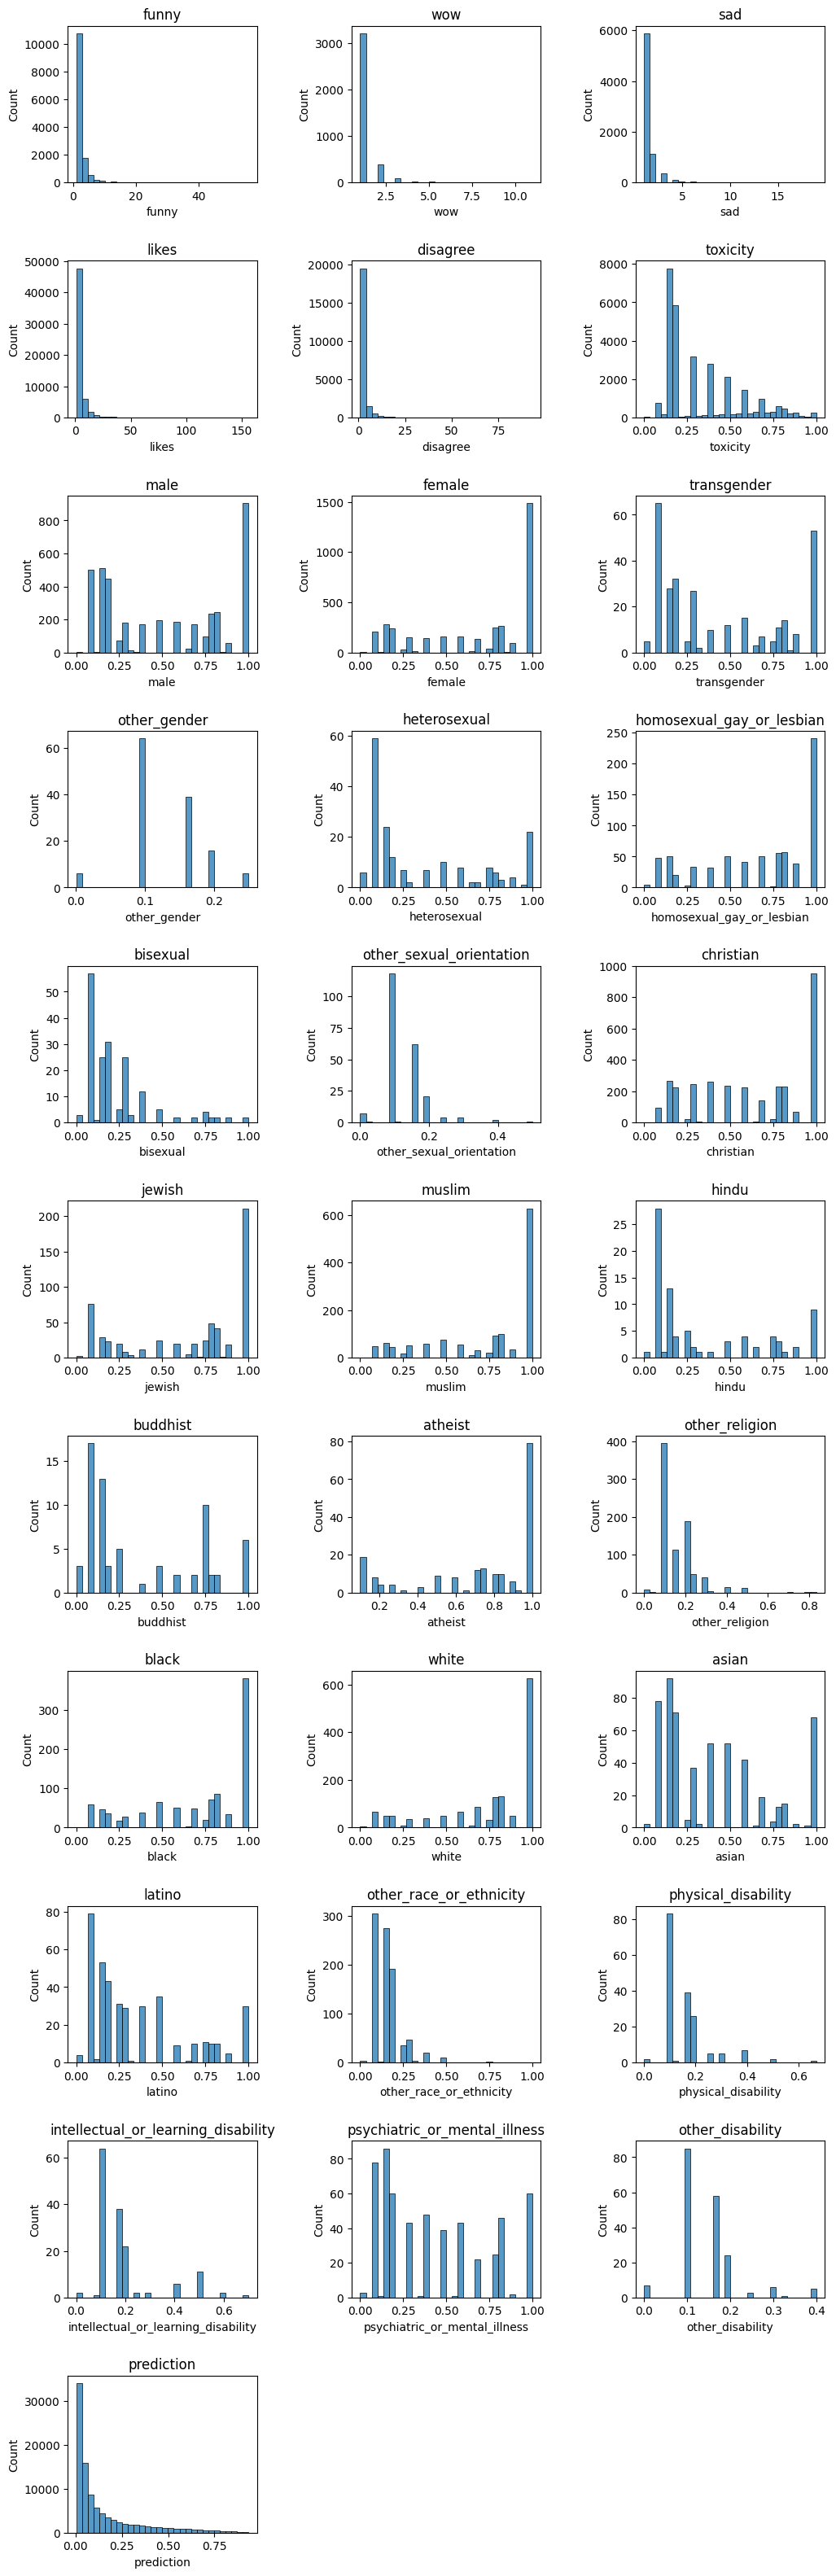

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_columns = 3
plot_rows = len(subpopulations) // plot_columns + 1

plt.figure(figsize=(12, 40))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i, subpopulation in enumerate(subpopulations):
    plt.subplot(plot_rows, plot_columns, i+1)
    # get number of bins 
    n_bins = 30 #test[subpopulation][test[subpopulation] != test[subpopulation].min()].nunique()
    sns.histplot(test[subpopulation][test[subpopulation] != test[subpopulation].min()], bins=n_bins)#, kde=True)
    plt.title(subpopulation)

In [14]:
# percent of values that are 0
(test[subpopulations] == 0).mean()

funny                                  0.861159
wow                                    0.961683
sad                                    0.921948
likes                                  0.412916
disagree                               0.773962
toxicity                               0.701510
male                                   0.180425
female                                 0.184001
transgender                            0.218598
other_gender                           0.220366
heterosexual                           0.219831
homosexual_gay_or_lesbian              0.214190
bisexual                               0.219831
other_sexual_orientation               0.219441
christian                              0.188471
jewish                                 0.215732
muslim                                 0.207994
hindu                                  0.220849
buddhist                               0.221003
atheist                                0.219780
other_religion                         0

In [15]:
# as we can see, most of the values are 0,

<Axes: >

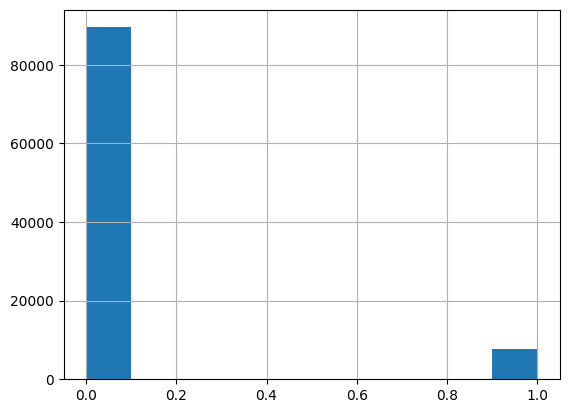

In [16]:
(test["toxicity"] >= 0.5).astype(int).hist()

In [17]:
# create a table with the results
results = pd.DataFrame(columns=["subpopulation", "AUC ROC", "False Positive Rate", "False Negative Rate", "Accuracy"])

for i, subpopulation in enumerate(subpopulations):
    if subpopulation in ["toxicity", "prediction"]: # "other_gender", "other_sexual_orientation", "other_religion"
        continue
    if len(test[test[subpopulation] > 0.5]) == 0:
        continue
    if len((test[test[subpopulation] > 0.5]['toxicity'] >= 0.5).astype(int).value_counts()) == 1:
        continue

    #print(subpopulation)
    #print("AUC ROC:", roc_auc_score((test[test[subpopulation] > 0.5]['toxicity'] >= 0.5).astype(int), (test[test[subpopulation] > 0.5]['prediction'] >= 0.5).astype(int)))
    # False Positive 
    fp = ((test[test[subpopulation] > 0.5]['toxicity'] < 0.5) & (test[test[subpopulation] > 0.5]['prediction'] >= 0.5)).sum()
    # False Negative
    fn = ((test[test[subpopulation] > 0.5]['toxicity'] >= 0.5) & (test[test[subpopulation] > 0.5]['prediction'] < 0.5)).sum()
    # True Positive
    tp = ((test[test[subpopulation] > 0.5]['toxicity'] >= 0.5) & (test[test[subpopulation] > 0.5]['prediction'] >= 0.5)).sum()
    # True Negative
    tn = ((test[test[subpopulation] > 0.5]['toxicity'] < 0.5) & (test[test[subpopulation] > 0.5]['prediction'] < 0.5)).sum()
    #print("False Positive:", fp)
    #print("False Negative:", fn)
    #print("True Positive:", tp)
    #print("True Negative:", tn)
    #print("False Positive Rate:", fp / (fp + tn))
    #print("False Negative Rate:", fn / (fn + tp))
    #print("Accuracy:", (tp + tn) / (tp + tn + fp + fn))

    results = results.append({"subpopulation": subpopulation,
                                "AUC ROC": roc_auc_score((test[test[subpopulation] > 0.5]['toxicity'] >= 0.5).astype(int), (test[test[subpopulation] > 0.5]['prediction'] >= 0.5).astype(int)),
                                "False Positive Rate": fp / (fp + tn),
                                "False Negative Rate": fn / (fn + tp),
                                "Accuracy": (tp + tn) / (tp + tn + fp + fn)}, ignore_index=True)
    
results





/tmp/ipykernel_1301194/1044890504.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"subpopulation": subpopulation,
/tmp/ipykernel_1301194/1044890504.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"subpopulation": subpopulation,
/tmp/ipykernel_1301194/1044890504.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"subpopulation": subpopulation,
/tmp/ipykernel_1301194/1044890504.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"subpopulation": subpopulation,
/tmp/ipykernel_1301194/1044890504.py:30: FutureWarning: The fram

,subpopulation,AUC ROC,False Positive Rate,False Negative Rate,Accuracy
0,funny,0.841448,0.023095,0.294009,0.955151
1,wow,0.812379,0.026269,0.348974,0.944221
2,sad,0.823116,0.025921,0.327846,0.945103
3,likes,0.823155,0.022379,0.331312,0.953549
4,disagree,0.818546,0.025995,0.336912,0.946359
5,male,0.778154,0.037332,0.406360,0.908190
6,female,0.769361,0.023212,0.438066,0.920557
7,transgender,0.676075,0.064516,0.583333,0.829060
8,heterosexual,0.840909,0.068182,0.250000,0.892857
9,homosexual_gay_or_lesbian,0.712428,0.075145,0.500000,0.801230


In [18]:
import shap

# print the JS visualization code to the notebook
shap.initjs()


In [19]:
shap_df = test.copy()
items = np.array(tokenize(shap_df["comment_text"], vocab))
shap_df["tokenized"] = items.tolist()
shap_df = shap_df[["tokenized"]]
shap_df.head()

,tokenized
id,
7097320,"[872, 2011, 355, 10, 15, 148, 47, 6599, 1, 874..."
7097321,"[24, 8, 10122, 42, 2, 8513, 5, 2, 752, 1, 23, ..."
7097322,"[1630, 17753, 13, 3029, 61, 7, 291, 4743, 1, 3..."
7097323,"[1093, 65, 411, 15, 16, 47, 396, 460, 1, 17, 2..."
7097324,"[504, 15, 1384, 261, 300, 1, 7796, 1387, 2513,..."


In [20]:
def to_tokens(texts):
    return np.array(tokenize(texts, vocab))


def shap_inference(sentences):
    #print(sentences[0][0])
    sentences = np.array([sentence[0] for sentence in sentences])
    
    print(sentences)
    #sentences = [sentence[0] for sentence in df]
    #sentences = to_tokens(sentences)
    return inference(sentences, models, tokenized=True)


In [21]:
import shap


class QuaziTokenizer():
    """From SHAP docs:
    'input_ids' and then either include
            an 'offset_mapping' entry in the same dictionary or provide a .convert_ids_to_tokens or .decode method."""
    
    def __init__(self, vocab):
        self.vocab = vocab
        self.mask_token_id = 0
        self.mask_token = "<PAD>"

    def __call__(self, text):
        if type(text) == str:
            result = tokenize([text], self.vocab)
            result = np.array(result)[0]
        else:
            result = tokenize(text, self.vocab)
            #print("REs", result[0])
        
        result = np.array(result)
        result = result[result != 0]
        return {"input_ids": result}
    


    def decode(self, input_ids):
        result = []
        for i in input_ids:

            result.append(str(self.vocab["id2token"][str(i)]))

            
        return "".join(result)

def shap_inference(sentences):
    sentences = np.array([sentence for sentence in sentences])
    return inference(sentences, models)

quazi_tokenizer = shap.maskers.Text(QuaziTokenizer(vocab), collapse_mask_token=True)
#quazi_tokenizer = shap.maskers.FixedComposite(quazi_tokenizer)


shap_df = test.copy()
items = np.array(tokenize(shap_df["comment_text"], vocab))
shap_df["tokenized"] = items.tolist()
#shap_df = shap_df[["tokenized"]]
shap_df.head()
item = [shap_df["comment_text"].to_list()[259]]

explainer = shap.Explainer(shap_inference, quazi_tokenizer)
shap_values = explainer(item)

In [22]:
shap.plots.text(shap_values)

In [23]:
shap_values

.values =
array([[ 0.07306271,  0.02417845, -0.03031238,  0.01904015, -0.03544505,
         0.00904322,  0.0016953 , -0.00438958, -0.04214605,  0.00806892,
        -0.03542176,  0.00301934,  0.02033886,  0.00583341,  0.03103602]])

.base_values =
array([0.03271384])

.data =
(array(['jesuits', ' are', ' .', ' of', ' course', ' ,', ' the', ' next',
       ' question', ' is', ' whether', ' they', ' are', ' catholics',
       ' .'], dtype=object),)

In [32]:
shaps = []

subset = test[(test["toxicity"] >= 0.5).astype(int) != (test["prediction"] >= 0.5).astype(int)].sample(n=354) # 95% confidence interval, 5% margin error

N_skip = 1

for i in tqdm(range(0, len(subset), N_skip), desc='Calculating SHAP values'):
    item = subset["comment_text"].to_list()[i:i+N_skip]
    try:
        shap_values = explainer(item)
        shaps.append(shap_values)
    except:
        pass

Calculating SHAP values: 100%|██████████| 354/354 [24:10<00:00,  4.10s/it]


In [34]:
shap.plots.text(shaps[0])

In [35]:
shaps[0]

.values =
array([[ 2.14816652e-03,  6.43695901e-03, -1.63460355e-03,
        -1.68681149e-03,  1.61126592e-03, -3.79255403e-03,
         1.19382898e-02, -2.04930727e-02,  2.14044594e-03,
        -1.35719988e-02,  5.71270229e-05,  1.95502935e-02,
         7.51576533e-02, -4.08620720e-03,  2.63759862e-02,
         6.09753072e-02,  4.65190064e-02,  2.95097601e-01,
        -2.57482602e-02, -6.10077604e-03,  5.69855898e-02]])

.base_values =
array([0.03271384])

.data =
(array(['they', ' bend', ' over', ' backwards', ' and', ' the', ' country',
       ' bends', ' over', ' forward', ' to', ' be', ' shafted', ' by',
       ' a', ' bunch', ' of', ' crooks', ' yet', ' again', ' .'],
      dtype=object),)

In [54]:
total_shaps = {}

for shap_values in shaps:
    for i, shap_value in enumerate(shap_values.values[0]):
        #print(shap_value)
        key = str(shap_values.data[0][i])
        #print(key)
        if key not in total_shaps:
            total_shaps[key] = {"positive": [], "negative": []}
        
        
        if shap_value >= 0:
            total_shaps[key]["positive"].append(shap_value)
        else:
            total_shaps[key]["negative"].append(shap_value)


for key in total_shaps.keys():
    total_shaps[key]["total"] = np.mean(total_shaps[key]["positive"] + total_shaps[key]["negative"])
    total_shaps[key]["positive"] = np.mean(total_shaps[key]["positive"])
    total_shaps[key]["negative"] = np.mean(total_shaps[key]["negative"])

total_shaps.keys()

/home/robinhad/Projects/respethics/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robinhad/Projects/respethics/env/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


dict_keys(['they', ' bend', ' over', ' backwards', ' and', ' the', ' country', ' bends', ' forward', ' to', ' be', ' shafted', ' by', ' a', ' bunch', ' of', ' crooks', ' yet', ' again', ' .', 'do', ' you', ' consider', ' every', ' "', ' black', ' lives', ' matter', ' supporter', ' responsible', ' for', ' death', ' each', ' cop', ' assassinated', ' other', ' blm', ' supporters', ' ?', ' probably', ' not', ' was', ' this', ' white', ' supremacist', ' rally', ' absolutely', ' organized', ' protest', ' removal', ' certain', ' southern', ' heritage', ' monuments', ' in', ' city', ' did', ' some', ' groups', ' show', ' up', ' certainly', ' antifa', ' all', ' left', ' -', ' wing', ' anti', ' protestors', ' specifically', ' provoke', ' violence', ' antagonize', ' citizens', ' who', ' were', ' lawfully', ' trying', ' assemble', ' exercise', ' their', ' first', ' amendment', ' right', ' are', ' darn', ' they', ' man', ' that', ' occurred', ' any', ' more', ' than', ' founder', ' is', ' one', ' i

In [59]:
total_shaps_df = pd.DataFrame.from_dict(total_shaps, orient="index")
total_shaps_df

,positive,negative,total
they,0.001399,NaN,0.001399
bend,0.006437,NaN,0.006437
over,0.002876,-0.003959,-0.002095
backwards,NaN,-0.001687,-0.001687
and,0.005149,-0.002075,0.000426
...,...,...,...
polezniye,0.001125,NaN,0.001125
duraki,0.020597,NaN,0.020597
compare,NaN,-0.006442,-0.006442
murderer,0.109232,NaN,0.109232


In [60]:
total_shaps_df.sort_values("total")

,positive,negative,total
lily,NaN,-0.100402,-0.100402
predictions,NaN,-0.071421,-0.071421
tasks,NaN,-0.067810,-0.067810
lite,NaN,-0.066263,-0.066263
hauled,NaN,-0.061216,-0.061216
...,...,...,...
fools,0.561026,NaN,0.561026
garbage,0.571545,NaN,0.571545
dumber,0.584777,NaN,0.584777
damn,0.682701,NaN,0.682701


In [66]:
diff_df = total_shaps_df.copy().dropna()
diff_df[abs(diff_df["total"]) > 0.01].sort_values("positive")[diff_df["positive"] > 0.05]

/tmp/ipykernel_1301194/1571850221.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  diff_df[abs(diff_df["total"]) > 0.01].sort_values("positive")[diff_df["positive"] > 0.05]


,positive,negative,total
arrested,0.052604,-0.000860,0.025872
death,0.053096,-0.001722,0.039392
punish,0.053964,-0.002996,0.039724
bunch,0.055798,-0.002108,0.036496
violent,0.058449,-0.000383,0.043741
hours,0.058543,-0.001699,0.018382
establishment,0.060011,-0.001137,0.029437
white,0.061054,-0.001080,0.058465
beat,0.068335,-0.002225,0.033055
destroy,0.070726,-0.000678,0.060526
